In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

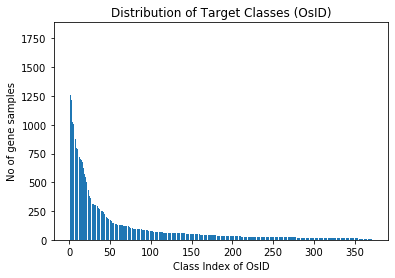

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=120, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 6s 3ms/step - loss: 5.0190 - accuracy: 0.0396 - val_loss: 4.9502 - val_accuracy: 0.0315
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6102 - accuracy: 0.0856 - val_loss: 4.3798 - val_accuracy: 0.1373
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0993 - accuracy: 0.1251 - val_loss: 4.0910 - val_accuracy: 0.1373
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8480 - accuracy: 0.1400 - val_loss: 3.8771 - val_accuracy: 0.1817
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6023 - accuracy: 0.1833 - val_loss: 3.6640 - val_accuracy: 0.1560
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3456 - accuracy: 0.2253 - val_loss: 3.4247 - val_accuracy: 0.2048
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1339 - accuracy: 0.2523 - val_loss: 3.2876 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 4.9938 - accuracy: 0.0412 - val_loss: 4.8555 - val_accuracy: 0.0315
Epoch 2/120
1846/1846 [==============================] - 5s 2ms/step - loss: 4.4115 - accuracy: 0.1010 - val_loss: 4.2313 - val_accuracy: 0.1149
Epoch 3/120
1846/1846 [==============================] - 5s 2ms/step - loss: 3.7446 - accuracy: 0.2146 - val_loss: 3.3125 - val_accuracy: 0.3347
Epoch 4/120
1846/1846 [==============================] - 5s 2ms/step - loss: 2.7576 - accuracy: 0.3925 - val_loss: 2.6197 - val_accuracy: 0.4570
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1816 - accuracy: 0.4854 - val_loss: 2.1749 - val_accuracy: 0.5692
Epoch 6/120
1846/1846 [==============================] - 5s 2ms/step - loss: 1.8013 - accuracy: 0.5599 - val_loss: 2.0078 - val_accuracy: 0.5589
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5770 - accuracy: 0.6074 - val_loss: 1.8296 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.9091 - accuracy: 0.0594 - val_loss: 4.4898 - val_accuracy: 0.1520
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1528 - accuracy: 0.1395 - val_loss: 4.0462 - val_accuracy: 0.2066
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7368 - accuracy: 0.1987 - val_loss: 3.7177 - val_accuracy: 0.1813
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3512 - accuracy: 0.2646 - val_loss: 3.2496 - val_accuracy: 0.3300
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7503 - accuracy: 0.3875 - val_loss: 2.6605 - val_accuracy: 0.4814
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2534 - accuracy: 0.4898 - val_loss: 2.3048 - val_accuracy: 0.4805
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8790 - accuracy: 0.5567 - val_loss: 1.9825 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8222 - accuracy: 0.0633 - val_loss: 4.1773 - val_accuracy: 0.1835
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5364 - accuracy: 0.3021 - val_loss: 3.2905 - val_accuracy: 0.3542
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7655 - accuracy: 0.4427 - val_loss: 2.7047 - val_accuracy: 0.4856
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1795 - accuracy: 0.5333 - val_loss: 2.3020 - val_accuracy: 0.5501
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7854 - accuracy: 0.6031 - val_loss: 1.9820 - val_accuracy: 0.6546
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5376 - accuracy: 0.6519 - val_loss: 1.8239 - val_accuracy: 0.6572
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3547 - accuracy: 0.6826 - val_loss: 1.6696 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.6336 - accuracy: 0.0814 - val_loss: 4.0033 - val_accuracy: 0.1927
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3682 - accuracy: 0.3190 - val_loss: 3.0876 - val_accuracy: 0.4130
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5827 - accuracy: 0.4577 - val_loss: 2.5544 - val_accuracy: 0.5226
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0851 - accuracy: 0.5211 - val_loss: 2.1756 - val_accuracy: 0.5520
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7385 - accuracy: 0.5825 - val_loss: 1.9892 - val_accuracy: 0.5580
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5095 - accuracy: 0.6366 - val_loss: 1.7845 - val_accuracy: 0.6735
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3582 - accuracy: 0.6671 - val_loss: 1.7373 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.9162 - accuracy: 0.0605 - val_loss: 4.3939 - val_accuracy: 0.1083
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7744 - accuracy: 0.2326 - val_loss: 3.4876 - val_accuracy: 0.3404
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9315 - accuracy: 0.4152 - val_loss: 2.8696 - val_accuracy: 0.4594
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3484 - accuracy: 0.5014 - val_loss: 2.4526 - val_accuracy: 0.5982
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9245 - accuracy: 0.5863 - val_loss: 2.1396 - val_accuracy: 0.6070
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6245 - accuracy: 0.6366 - val_loss: 1.9386 - val_accuracy: 0.6671
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4163 - accuracy: 0.6811 - val_loss: 1.8261 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 3ms/step - loss: 4.6473 - accuracy: 0.0793 - val_loss: 3.9779 - val_accuracy: 0.1987
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3167 - accuracy: 0.3213 - val_loss: 3.0299 - val_accuracy: 0.4000
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4816 - accuracy: 0.5025 - val_loss: 2.4720 - val_accuracy: 0.5650
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9605 - accuracy: 0.5862 - val_loss: 2.0745 - val_accuracy: 0.6077
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6161 - accuracy: 0.6361 - val_loss: 1.8390 - val_accuracy: 0.6550
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3884 - accuracy: 0.6768 - val_loss: 1.6875 - val_accuracy: 0.6660
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2271 - accuracy: 0.7028 - val_loss: 1.5489 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5487 - accuracy: 0.0806 - val_loss: 4.0285 - val_accuracy: 0.1331
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6286 - accuracy: 0.1948 - val_loss: 3.4752 - val_accuracy: 0.2132
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9136 - accuracy: 0.4090 - val_loss: 2.8052 - val_accuracy: 0.5091
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2733 - accuracy: 0.5289 - val_loss: 2.4014 - val_accuracy: 0.5452
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8503 - accuracy: 0.6002 - val_loss: 2.0972 - val_accuracy: 0.6238
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5485 - accuracy: 0.6610 - val_loss: 1.9478 - val_accuracy: 0.6715
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3617 - accuracy: 0.6912 - val_loss: 1.7556 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5932 - accuracy: 0.0772 - val_loss: 4.1199 - val_accuracy: 0.0961
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5118 - accuracy: 0.2597 - val_loss: 3.1483 - val_accuracy: 0.3725
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5008 - accuracy: 0.4834 - val_loss: 2.3732 - val_accuracy: 0.5135
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8410 - accuracy: 0.5917 - val_loss: 1.9399 - val_accuracy: 0.6266
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4572 - accuracy: 0.6667 - val_loss: 1.6741 - val_accuracy: 0.6750
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1913 - accuracy: 0.7174 - val_loss: 1.4813 - val_accuracy: 0.7351
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.0216 - accuracy: 0.7521 - val_loss: 1.3456 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 10s 4ms/step - loss: 4.5281 - accuracy: 0.0808 - val_loss: 4.1143 - val_accuracy: 0.1256
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6691 - accuracy: 0.1799 - val_loss: 3.5502 - val_accuracy: 0.1855
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0504 - accuracy: 0.3140 - val_loss: 2.8565 - val_accuracy: 0.4233
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2911 - accuracy: 0.5204 - val_loss: 2.2718 - val_accuracy: 0.5391
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7457 - accuracy: 0.6233 - val_loss: 1.8711 - val_accuracy: 0.6528
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3983 - accuracy: 0.6855 - val_loss: 1.6318 - val_accuracy: 0.6616
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1789 - accuracy: 0.7239 - val_loss: 1.4538 - val_accuracy: 0.7

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 3ms/step - loss: 4.8055 - accuracy: 0.0666 - val_loss: 4.3281 - val_accuracy: 0.0992
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9154 - accuracy: 0.1360 - val_loss: 3.7416 - val_accuracy: 0.2638
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2789 - accuracy: 0.3259 - val_loss: 3.1804 - val_accuracy: 0.3534
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6203 - accuracy: 0.4479 - val_loss: 2.6209 - val_accuracy: 0.5124
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0007 - accuracy: 0.5577 - val_loss: 2.1642 - val_accuracy: 0.6147
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5824 - accuracy: 0.6500 - val_loss: 1.9009 - val_accuracy: 0.6671
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3164 - accuracy: 0.6999 - val_loss: 1.7505 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5711 - accuracy: 0.0808 - val_loss: 4.1648 - val_accuracy: 0.0977
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7013 - accuracy: 0.1678 - val_loss: 3.5356 - val_accuracy: 0.1963
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1545 - accuracy: 0.2341 - val_loss: 3.1064 - val_accuracy: 0.3289
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6648 - accuracy: 0.3784 - val_loss: 2.6701 - val_accuracy: 0.4752
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1461 - accuracy: 0.5133 - val_loss: 2.2809 - val_accuracy: 0.5694
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7288 - accuracy: 0.5978 - val_loss: 1.9201 - val_accuracy: 0.6110
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4452 - accuracy: 0.6511 - val_loss: 1.7306 - val_accuracy: 0.66

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 6s 2ms/step - loss: 4.7148 - accuracy: 0.0708 - val_loss: 4.1627 - val_accuracy: 0.1197
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6833 - accuracy: 0.2068 - val_loss: 3.4773 - val_accuracy: 0.3371
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8795 - accuracy: 0.3997 - val_loss: 2.7169 - val_accuracy: 0.4662
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1071 - accuracy: 0.5538 - val_loss: 2.1484 - val_accuracy: 0.6068
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6277 - accuracy: 0.6471 - val_loss: 1.8676 - val_accuracy: 0.6458
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3328 - accuracy: 0.6980 - val_loss: 1.6798 - val_accuracy: 0.6986
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1665 - accuracy: 0.7201 - val_loss: 1.5363 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.5820 - accuracy: 0.0781 - val_loss: 4.1599 - val_accuracy: 0.1197
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7178 - accuracy: 0.1700 - val_loss: 3.5137 - val_accuracy: 0.2176
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9494 - accuracy: 0.3476 - val_loss: 2.7711 - val_accuracy: 0.4361
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1721 - accuracy: 0.5326 - val_loss: 2.1353 - val_accuracy: 0.5872
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6125 - accuracy: 0.6335 - val_loss: 1.7383 - val_accuracy: 0.6601
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2967 - accuracy: 0.6913 - val_loss: 1.5618 - val_accuracy: 0.6988
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1236 - accuracy: 0.7223 - val_loss: 1.4431 - val_accuracy: 0.71

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5228 - accuracy: 0.0844 - val_loss: 4.0650 - val_accuracy: 0.1197
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5856 - accuracy: 0.1814 - val_loss: 3.4303 - val_accuracy: 0.2002
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9631 - accuracy: 0.3037 - val_loss: 2.8080 - val_accuracy: 0.4310
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2783 - accuracy: 0.5053 - val_loss: 2.1933 - val_accuracy: 0.5705
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7587 - accuracy: 0.6057 - val_loss: 1.8279 - val_accuracy: 0.6392
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4218 - accuracy: 0.6674 - val_loss: 1.5525 - val_accuracy: 0.7164
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1976 - accuracy: 0.7142 - val_loss: 1.3463 - val_accuracy: 0.74

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 6s 2ms/step - loss: 4.9376 - accuracy: 0.0468 - val_loss: 4.7519 - val_accuracy: 0.0548
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 4.4474 - accuracy: 0.0788 - val_loss: 4.2273 - val_accuracy: 0.0700
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8490 - accuracy: 0.1590 - val_loss: 3.7357 - val_accuracy: 0.1844
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4107 - accuracy: 0.2133 - val_loss: 3.3443 - val_accuracy: 0.2268
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9856 - accuracy: 0.2927 - val_loss: 2.9520 - val_accuracy: 0.3259
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5495 - accuracy: 0.3927 - val_loss: 2.5649 - val_accuracy: 0.4392
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1272 - accuracy: 0.4999 - val_loss: 2.2291 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.6660 - accuracy: 0.0708 - val_loss: 4.1397 - val_accuracy: 0.1254
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7982 - accuracy: 0.1562 - val_loss: 3.6503 - val_accuracy: 0.1712
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3143 - accuracy: 0.2251 - val_loss: 3.2030 - val_accuracy: 0.2565
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8231 - accuracy: 0.3281 - val_loss: 2.7442 - val_accuracy: 0.3897
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3599 - accuracy: 0.4323 - val_loss: 2.3638 - val_accuracy: 0.4860
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0261 - accuracy: 0.4934 - val_loss: 2.1637 - val_accuracy: 0.5030
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7960 - accuracy: 0.5431 - val_loss: 1.9433 - val_accuracy: 0.52

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.7336 - accuracy: 0.0735 - val_loss: 4.2705 - val_accuracy: 0.1369
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8840 - accuracy: 0.1553 - val_loss: 3.7598 - val_accuracy: 0.1512
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4615 - accuracy: 0.1945 - val_loss: 3.4135 - val_accuracy: 0.2174
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0579 - accuracy: 0.2742 - val_loss: 2.9696 - val_accuracy: 0.3199
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5547 - accuracy: 0.3939 - val_loss: 2.5225 - val_accuracy: 0.4244
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1753 - accuracy: 0.4797 - val_loss: 2.2626 - val_accuracy: 0.4737
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9113 - accuracy: 0.5280 - val_loss: 2.0441 - val_accuracy: 0.52

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.9672 - accuracy: 0.0463 - val_loss: 4.7478 - val_accuracy: 0.0491
Epoch 2/120
1846/1846 [==============================] - 3s 2ms/step - loss: 4.3861 - accuracy: 0.0933 - val_loss: 4.1191 - val_accuracy: 0.1281
Epoch 3/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7445 - accuracy: 0.1810 - val_loss: 3.6388 - val_accuracy: 0.1721
Epoch 4/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.3421 - accuracy: 0.2309 - val_loss: 3.3265 - val_accuracy: 0.2350
Epoch 5/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.0001 - accuracy: 0.2974 - val_loss: 3.0220 - val_accuracy: 0.3340
Epoch 6/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6622 - accuracy: 0.3623 - val_loss: 2.7276 - val_accuracy: 0.4013
Epoch 7/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.3578 - accuracy: 0.4339 - val_loss: 2.4757 - val_accuracy: 0.44

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 4.8580 - accuracy: 0.0564 - val_loss: 4.5540 - val_accuracy: 0.0810
Epoch 2/120
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1434 - accuracy: 0.1222 - val_loss: 4.0245 - val_accuracy: 0.1681
Epoch 3/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7111 - accuracy: 0.1812 - val_loss: 3.6674 - val_accuracy: 0.1573
Epoch 4/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4057 - accuracy: 0.2092 - val_loss: 3.4024 - val_accuracy: 0.2103
Epoch 5/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1482 - accuracy: 0.2412 - val_loss: 3.1863 - val_accuracy: 0.2653
Epoch 6/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9105 - accuracy: 0.2848 - val_loss: 2.9923 - val_accuracy: 0.2999
Epoch 7/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.7049 - accuracy: 0.3305 - val_loss: 2.8288 - val_accuracy: 0.36

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

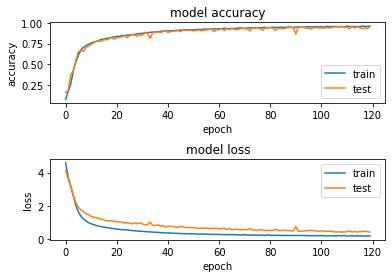

Final Test Accuracy: 0.9706640839576721


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.92      1.00      0.96       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       0.97      1.00      0.98       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os01g0862800         329              101       False
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.418
1,2,0.850
2,3,0.893
3,4,0.925
4,5,0.917
5,6,0.930
6,7,0.949
7,8,0.937
8,9,0.905
9,10,0.959
